**Наша задача:**
Построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

В базовом решении метрика MAPE была 14.13.
Решение включало в себя заполнение значением "0" пустых значений в признаках lat и lng, и удалением всех признаков типа "object".

Попробуем улучшить результат.

In [1]:
pip install nltk[twitter] 

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# инструмент для обработки текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.download('vader_lexicon')


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Знакомство с данными

In [5]:
# Загрузим данные

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [50]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [8]:
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


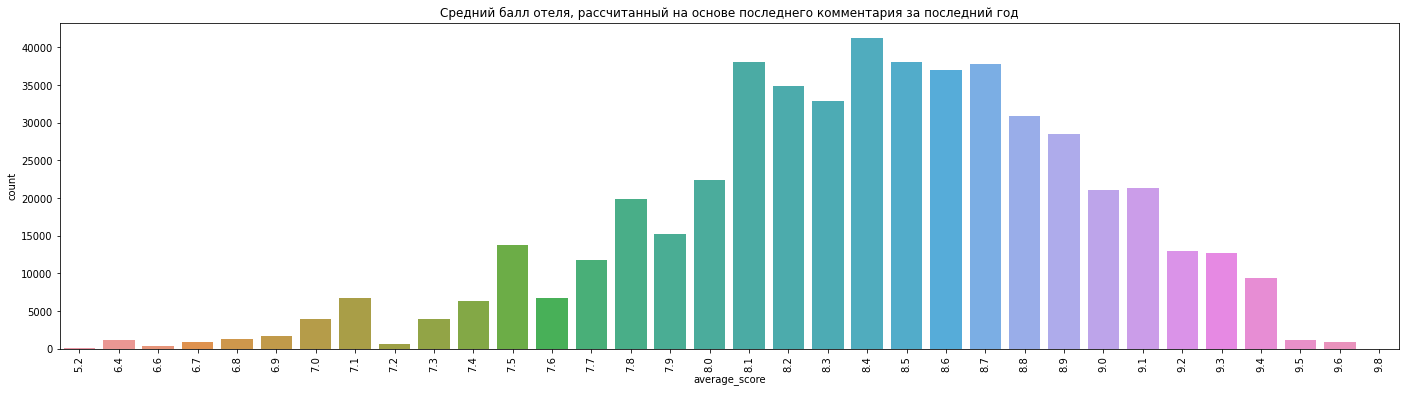

In [10]:
# посмотрим на выставленные оценки отелям. признак average_score
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
ax = sns.countplot(x=data.average_score)
ax.set_title("Cредний балл отеля, рассчитанный на основе последнего комментария за последний год")
plt.show()

При первом взгляде на данные я вижу, что пустые значения только у двух признаков lat и lng.

А так же большое количество категориальных признаков, которые нельзя подать на вход нашей модели.

Среди интересных признаков, которые могут иметь большой вес в формировании рейтинга отеля, я бы выделила:

* **negative_review**, **positive_review** - собственно негативный и положительный отзывы. 

* **review_date** (object) - дата, когда отзыв был размещен. этот признак перекликается с **days_since_review** (object) - сколько дней отзыву. Если отзыв давнишний, то он должен иметь меньший вес, нежели свежий отзыв.


# 2. Очистка данных

Пустые значения в двух признаках lat и lng - широта и долгота отеля, которые дублируют признак hotel_address (адрес отеля). Удалим эти столбцы.

In [70]:
# чистим пустые значения
data = data.drop(['lat', 'lng'], axis = 1)

In [51]:
# из базового решения подготовки данных. ВНИМАНИЕ! так 0 заполнится весь столбец полностью, а не только пустые значения!
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

# буду заполнять "0" ТОЛЬКО None-ы
data['lat'].fillna(0, inplace=True)
data['lng'].fillna(0, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
# Удаление дубликатов показало улучшение метрики на сотую долю. Но на Kaggle проводить ее не буду, а то 
# поедет вся отчетность. Т.к. в загружаемой таблице sample_submission из файла submission.csv присутствуют 
# и удаленные на этапе удаления дубликатов айдишники. Не сможем загрузить туда наши предсказанные рутинги, т.к.
# не будут совпадать len(predict_submission)    - 128906   и   len(sample_submission)   - 128935.


# ищем и удаляем дубликаты
#print(f'Число записей: {data.shape[0]}')

#dupl_columns = list(data.columns)

# создали маску дубликатов и производим фильтрацию
#mask_d = data.duplicated(subset=dupl_columns)
#data_duplicates = data[mask_d]
#print(f'Число найденных полных дубликатов: {data_duplicates.shape[0]}')

#data = data.drop_duplicates(subset=dupl_columns)#, inplace=True, ignore_index=True)
#print(f'Результирующее число записей: {data.shape[0]}')

Число записей: 515738
Число найденных полных дубликатов: 336
Результирующее число записей: 515402


# 3. Исследование и проектирование признаков

In [24]:
# дело будем иметь с 1492 отелями
data['hotel_name'].unique().shape[0]

1492

In [15]:
# сколько у нас адресов
data['hotel_address'].describe()

count                                                515402
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   4789
Name: hotel_address, dtype: object

# - Признак **negative_review** и **positive_review**

In [16]:
data['negative_review'].value_counts()

No Negative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              127807
 Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  14291
 Nothing

По сути наш отзыв состоит из двух частей: "Что понравилось?" и "Что не понравилось?" Поэтому в целом положительный отзыв может содержать в столбце "negative_review" значение "No Negative", т.е. там тоже будет что-то написано.

Я хочу проанализировать признаки с отзывами с помощью **SentimentIntensityAnalyzer** из библиотеки **nltk**. 

In [52]:
sent_analyzer = SentimentIntensityAnalyzer()

In [18]:
# пример работы функции

rev1 = "Cleanliness the walls are dirty Battery sink it s too short you can not wash No wardrobe in the room "
rev2 = "No Negative"
rev3 = "nothing"
rev4 = "small room"
rev5 = "nothing at all"
rev6 = "nothing really"
rev7 = "price"

print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")

print(f"\nreview 3:\n{rev3}\nScore: {sent_analyzer.polarity_scores(rev3)}")

print(f"\nreview 4:\n{rev4}\nScore: {sent_analyzer.polarity_scores(rev4)}")

print(f"\nreview 5:\n{rev5}\nScore: {sent_analyzer.polarity_scores(rev5)}")

print(f"\nreview 6:\n{rev6}\nScore: {sent_analyzer.polarity_scores(rev6)}")

print(f"\nreview 7:\n{rev7}\nScore: {sent_analyzer.polarity_scores(rev7)}")

review 1:
Cleanliness the walls are dirty Battery sink it s too short you can not wash No wardrobe in the room 
Score: {'neg': 0.133, 'neu': 0.78, 'pos': 0.087, 'compound': -0.2528}

review 2:
No Negative
Score: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

review 3:
nothing
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

review 4:
small room
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

review 5:
nothing at all
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

review 6:
nothing really
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

review 7:
price
Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [53]:
# приведем отзывы к нижнему регистру
data['negative_review'] = data['negative_review'].str.lower()
data['positive_review'] = data['positive_review'].str.lower()

In [54]:
data['negative_review'].value_counts().head(50)

no negative                    127890
 nothing                        16627
 nothing                         4558
 n a                             1775
 none                            1297
                                  849
 breakfast                        502
 small room                       481
 location                         447
 all good                         385
 nothing really                   380
 everything                       374
 no complaints                    328
 nil                              310
 price                            302
 nothing really                   276
 na                               264
 nothing at all                   259
 small rooms                      245
 nothing to dislike               239
 nothing at all                   208
 none                             204
 no complaints                    195
 room size                        181
 no                               180
 expensive                        165
 staff      

In [55]:
# анализируем негативные отзывы
data['negative_review_nltk'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# анализируем позитивные отзывы
data['positive_review_nltk'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [57]:
# после анализатора получаем признаки со словарями. сформируем из них новые признаки по ключам словарей

data['negative_review_neg'] = data['negative_review_nltk'].apply(lambda x: x['neg'])
data['negative_review_neu'] = data['negative_review_nltk'].apply(lambda x: x['neu'])
data['negative_review_pos'] = data['negative_review_nltk'].apply(lambda x: x['pos'])
data['negative_review_compound'] = data['negative_review_nltk'].apply(lambda x: x['compound'])

data['positive_review_neg'] = data['positive_review_nltk'].apply(lambda x: x['neg'])
data['positive_review_neu'] = data['positive_review_nltk'].apply(lambda x: x['neu'])
data['positive_review_pos'] = data['positive_review_nltk'].apply(lambda x: x['pos'])
data['positive_review_compound'] = data['positive_review_nltk'].apply(lambda x: x['compound'])

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   negative_review_neg                         515738 non-null  float64
 9   negative_review_neu                         515738 non-null  float64
 

# - Признак **review_date**

In [26]:
# преобразуем признак даты в тип датавремя
data['review_date'] = pd.to_datetime(data['review_date'])

In [27]:
print('Самый свежий отзыв оставлен', data['review_date'].max())
print('Первый отзыв оставлен', data['review_date'].min())

Самый свежий отзыв оставлен 2017-08-03 00:00:00
Первый отзыв оставлен 2015-08-04 00:00:00


Моделе нельзя подать данные типа datetime, она их не поймет,но в нашем датасете есть признак **days_since_review**. В котором уже посчитано количество дней с написания отзыва. Его и будем использовать, только приведем к типу int.

# 4. Корреляция признаков

<AxesSubplot:>

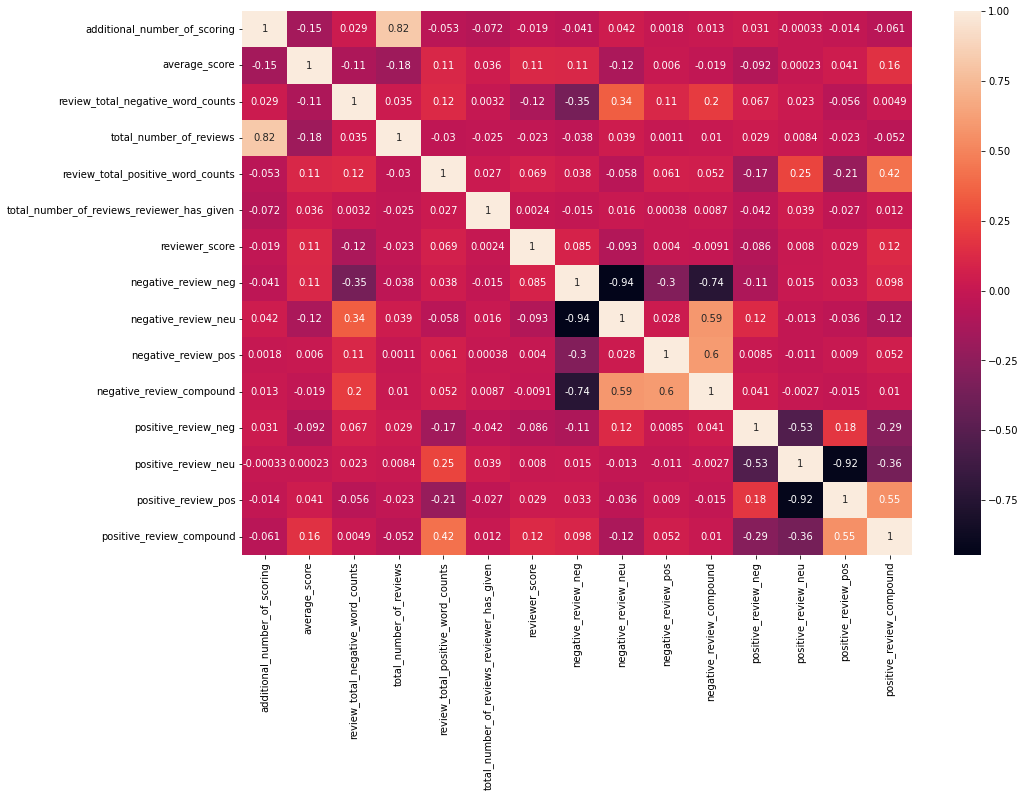

In [72]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [60]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# и datetime тоже удаляем
object_columns = [s for s in data.columns if (data[s].dtypes == 'object' or data[s].dtypes == 'datetime64[ns]')]
print('Удалили ', len(object_columns), ' признаков')
data.drop(object_columns, axis = 1, inplace=True)

Удалили  10  признаков


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   negative_review_neg                         515738 non-null  float64
 9   negative_review_neu                         515738 non-null  float64
 

In [74]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [75]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [76]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 15), (386803, 15), (386803, 14), (309442, 14), (77361, 14))

In [65]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [66]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [77]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


CPU times: user 7min 25s, sys: 2.36 s, total: 7min 27s
Wall time: 1min 56s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [78]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8903428129389739


MAE: 0.9822361453527125

MAE: 0.8859467676279675

In [79]:
# MAPE метрика - средняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.69


1. При первой обработке (заменили все lat и lng "0". и удалили все object) получили MAPE: 14.13
2. Если еще и избавиться от дубликатов метрика MAPE: 14.12
3. После удаления дублей, пустых значений (оба столбца lat и lng) и преобразовав признаки с отзывами получили MAPE: 12.64
4. если не удалять lat/lng, и не удалять дубликаты - MAPE: 12.7

<AxesSubplot:>

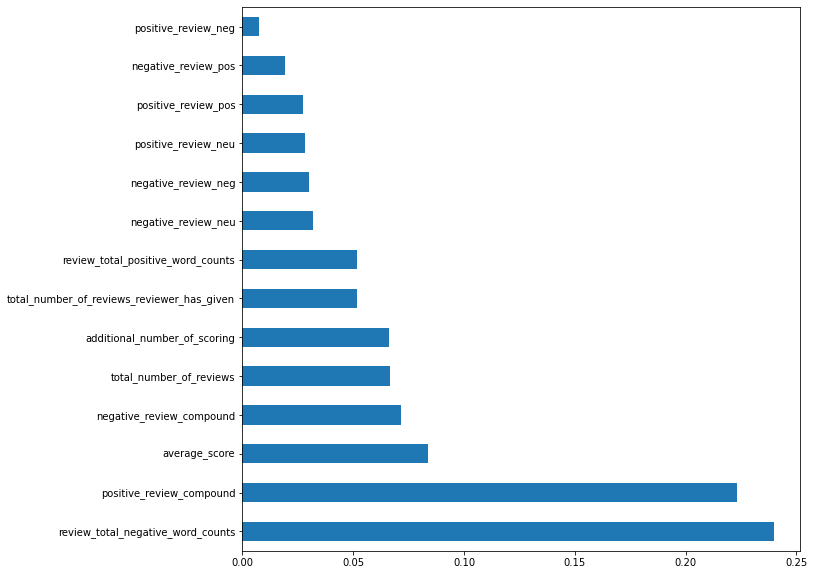

In [80]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [81]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [82]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [83]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [84]:
len(predict_submission), len(sample_submission)

(128935, 128935)

In [85]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.668,488440
1,7.594,274649
2,8.853,374688
3,9.762,404352
4,9.630,451596
5,9.076,302161
6,7.667,317079
7,7.606,13963
8,8.479,159785
9,7.882,195089
